In [248]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer  
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


In [249]:
df = pd.read_csv('/kaggle/input/sentimental-analysis-for-tweets/sentiment_tweets3.csv')

In [250]:
print(df.head())

   Index                                 message to examine  \
0    106  just had a real good moment. i missssssssss hi...   
1    217         is reading manga  http://plurk.com/p/mzp1e   
2    220  @comeagainjen http://twitpic.com/2y2lx - http:...   
3    288  @lapcat Need to send 'em to my accountant tomo...   
4    540      ADD ME ON MYSPACE!!!  myspace.com/LookThunder   

   label (depression result)  
0                          0  
1                          0  
2                          0  
3                          0  
4                          0  


In [251]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10314 entries, 0 to 10313
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Index                      10314 non-null  int64 
 1   message to examine         10314 non-null  object
 2   label (depression result)  10314 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 241.9+ KB
None


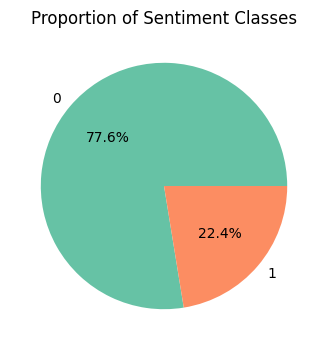

In [252]:
# Calculate the distribution
class_counts = df['label (depression result)'].value_counts()

# Plot the pie chart
plt.figure(figsize=(4, 4))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', colors=sns.color_palette('Set2', len(class_counts)))

# Adding title
plt.title('Proportion of Sentiment Classes')

# Show the plot
plt.show()

In [253]:
# Initialize stopwords and stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

In [254]:
# Text Preprocessing function
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove user mentions (e.g., @username)
    text = re.sub(r'@\w+', '', text)
    
    # Remove hashtags (e.g., #hashtag)
    text = re.sub(r'#\w+', '', text)
    
    # Remove special characters and punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove stopwords and apply stemming
    text = ' '.join(stemmer.stem(word) for word in text.split() if word not in stop_words)
    
    return text

In [255]:
df['cleaned_text'] = df['message to examine'].apply(clean_text)

In [256]:
df['cleaned_text'][4]

'add myspac myspacecomlookthund'

In [257]:
# Text preprocessing
texts = df['cleaned_text'].astype(str).tolist()
labels = df['label (depression result)'].tolist()

In [258]:
# Tokenize the text
tokenizer = Tokenizer(num_words=5000)  # limit the vocabulary size
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

In [259]:
# Pad sequences
maxlen = 100  # or any suitable length
X = pad_sequences(sequences, maxlen=maxlen)
y = np.array(labels)

In [260]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [267]:
# Handle class imbalance
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [268]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

In [269]:
# Define the LSTM model
model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=maxlen),
    LSTM(64, return_sequences=False),
    Dense(1, activation='sigmoid')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [270]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [271]:
# Train the model
history = model.fit(X_train_resampled, y_train_resampled, epochs=3, batch_size=64, validation_split=0.2, class_weight=class_weight_dict)

Epoch 1/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 18s 96ms/step - accuracy: 0.6319 - loss: 0.6034 - val_accuracy: 0.7213 - val_loss: 0.4143
Epoch 2/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.9216 - loss: 0.2806 - val_accuracy: 0.7025 - val_loss: 0.5086
Epoch 3/3
160/160 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.9385 - loss: 0.2069 - val_accuracy: 0.7045 - val_loss: 0.5713


In [272]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy:.2f}')
print(f'Test Loss: {loss:.2f}')

65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9122 - loss: 0.2946
Test Accuracy: 0.92
Test Loss: 0.27


In [273]:
# Predict on the test set
y_pred = (model.predict(X_test) > 0.5).astype(int)

65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


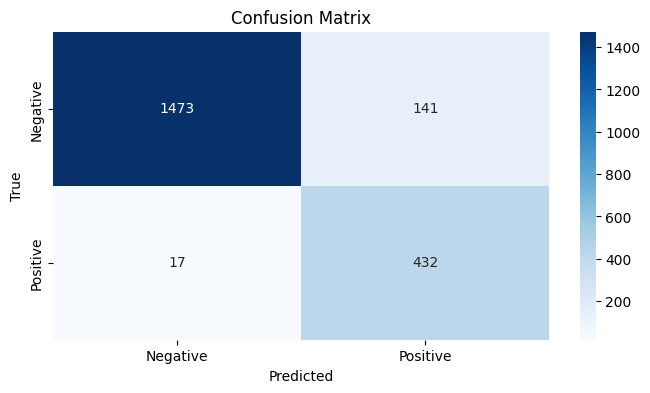

In [274]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [279]:
# Predict sentiments
def predict_sentiment(text):
    # Clean and preprocess the input text
    cleaned_text = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned_text])
    padded_seq = pad_sequences(seq, maxlen=maxlen)
    
    # Predict probabilities
    prob = model.predict(padded_seq)
    # Determine the predicted class based on probability
    predicted_class = 'Positive' if prob[0] < 0.5 else 'Negative'
    
    # Output the prediction and probability
    return predicted_class, prob[0]

In [286]:
# Example usage
sample_text = "I am very sad!"
predicted_class, predicted_prob = predict_sentiment(sample_text)
print(f"Predicted class: {predicted_class}, Probability: {predicted_prob}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted class: Negative, Probability: [0.51914]
